In [272]:
from matplotlib import pyplot as plt
import pandas as pd
import os.path as op
import mne
import scipy.io
import os
import glob
import csv
from mne.io import read_epochs_fieldtrip
from mne import create_info
import numpy as np
from burst_detection import extract_bursts
from burst_detection import extract_bursts_single_trial
from fooof import FOOOF
import mat73
import h5py
import json

In [273]:
def make_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.int64, np.float64)):
        return obj.item()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

In [278]:
def detect_bursts(age):
    
    subjects=[os.path.split(x)[-1] for x in glob.glob('/home/common/bonaiuto/devmobeta/data/sub-*')]
    subject_age_path=os.path.join('/home/common/bonaiuto/devmobeta/derivatives/')
    subjects= os.path.join(subject_age_path,'participants.csv')
    
    age_bursts=[]
    sfreq = 512
    
    subjects_path = '/home/common/bonaiuto/devmobeta/data/sub-*'
    subject_ids = [os.path.split(x)[-1] for x in glob.glob(subjects_path)]
    
    with open(subjects, 'r') as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t')
        for row in reader:
            print("Processing row:", row)
            subject=row['subject_id']
            session=row['session']
            subject_age = row['age']
                        
            if subject_age==age:
                sub_path=os.path.join('/home/common/bonaiuto/devmobeta/derivatives/',subject)
                ses_path=os.path.join(sub_path, session)
                if os.path.exists(os.path.join(ses_path,'eeg','NEARICA_NF')): 
                    print(f"Processing subject {subject} with age {subject_age} and session {session}")
                    superlet_path=os.path.join(ses_path,'eeg','NEARICA_NF')

                    eeg_path=os.path.join(ses_path,'eeg','NEARICA_NF')
                    fname = os.path.join(eeg_path, f'04_rereferenced_data/{subject}_task-devmobeta_grasp_eeg_rereferenced_data.set')
        
                    if os.path.exists(fname):
                        print(fname)
                        data = mne.read_epochs_eeglab(fname)
                        times = data.times
                        trials = data.get_data()[:, 11, :]
                        print(trials.shape)
                        print(times.shape) 
                    
                        if os.path.exists(superlet_path):

                            for epoch in ['go','grsp']:
                
                                epoch_fname = op.join(superlet_path, f'{subject}_processed_superlet_tf.mat{epoch}_processed_superlet_tf.mat')
                                print(epoch_fname)
                                if os.path.exists(epoch_fname):
                                    with h5py.File(epoch_fname, 'r') as f:                                    
                                        trial_tf = np.array(f['trial_tf'])
                                        foi=np.array(f['foi'])
                                        ch_idx=36
                                        print(trial_tf.shape) 
                                        print(foi.shape) 
                                        
                                        average_psd = np.mean(trial_tf[:,ch_idx,:,:], axis=(0, -1))
                                        trial_tf = trial_tf[:,ch_idx,:,:]
                                        print("Original trial_tf shape:", trial_tf.shape) 
                                        print(average_psd.shape) 

                                        trial_tf = np.transpose(trial_tf, (2, 1, 0))
                                        print("Transposed trial_tf shape:", trial_tf.shape)
                                
                                        search_range = np.where((foi >= 3) & (foi <= 23))[0]
                                        beta_lims = [6, 20] 
                                        print(average_psd.shape) 
                                
                                        ff = FOOOF()
                                        ff.fit(np.squeeze(foi), average_psd, [1, 50]) 
                                        ap = 10 ** ff._ap_fit 
                                        print(ap.shape)
                                
                                        bursts = extract_bursts(
                                            trials, trial_tf[:,search_range,:], times, 
                                            foi[search_range], beta_lims, 
                                             ap[search_range].reshape(-1,1), sfreq) 
                                        
                                        age_bursts.append({
                                            'subject': subject,
                                            'epoch': epoch,
                                            'bursts': bursts
                                        })

                                
            else:
                continue 
    
    age_bursts_serializable = json.loads(json.dumps(age_bursts, default=make_serializable))
    
    with open(f'bursts_{age}.json', 'w') as json_file:
        json.dump(age_bursts_serializable, json_file)
    
    return age_bursts

In [279]:
bursts_three = detect_bursts('three')
bursts_six = detect_bursts('six')
bursts_twelve = detect_bursts('twelve')

Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-01', 'age': 'three', 'sex': 'M'}
Processing subject sub-201 with age three and session ses-01
/home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-01/eeg/NEARICA_NF/04_rereferenced_data/sub-201_task-devmobeta_grasp_eeg_rereferenced_data.set
Extracting parameters from /home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-01/eeg/NEARICA_NF/04_rereferenced_data/sub-201_task-devmobeta_grasp_eeg_rereferenced_data.set...


/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Ready.
(21, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-01/eeg/NEARICA_NF/sub-201_processed_superlet_tf.matgo_processed_superlet_tf.mat


/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(3000, 129, 50, 21)
(50, 1)
Original trial_tf shape: (3000, 50, 21)
(50,)
Transposed trial_tf shape: (21, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-01/eeg/NEARICA_NF/sub-201_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 21)
(50, 1)
Original trial_tf shape: (3000, 50, 21)
(50,)
Transposed trial_tf shape: (21, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low 

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)


Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Ready.
(20, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-203/ses-02/eeg/NEARICA_NF/sub-203_processed_superlet_tf.matgo_processed_superlet_tf.mat


/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(3000, 129, 50, 20)
(50, 1)
Original trial_tf shape: (3000, 50, 20)
(50,)
Transposed trial_tf shape: (20, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-203/ses-02/eeg/NEARICA_NF/sub-203_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 20)
(50, 1)
Original trial_tf shape: (3000, 50, 20)
(50,)
Transposed trial_tf shape: (20, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small 

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(18, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-01/eeg/NEARICA_NF/sub-205_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 18)
(50, 1)
Original trial_tf shape: (3000, 50, 18)
(50,)
Transposed trial_tf shape: (18, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-01/eeg/NEARICA_NF/sub-205_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 18)
(50, 1)
Original trial_tf shape: (3000, 50, 18)
(50,)
Transposed trial_tf shape: (18, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(8, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-02/eeg/NEARICA_NF/sub-206_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 8)
(50, 1)
Original trial_tf shape: (3000, 50, 8)
(50,)
Transposed trial_tf shape: (8, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-02/eeg/NEARICA_NF/sub-206_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 8)
(50, 1)
Original trial_tf shape: (3000, 50, 8)
(50,)
Transposed trial_tf shape: (8, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequ

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(41, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-02/eeg/NEARICA_NF/sub-207_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 41)
(50, 1)
Original trial_tf shape: (3000, 50, 41)
(50,)
Transposed trial_tf shape: (41, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-02/eeg/NEARICA_NF/sub-207_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 41)
(50, 1)
Original trial_tf shape: (3000, 50, 41)
(50,)
Transposed trial_tf shape: (41, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= th

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(16, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-02/eeg/NEARICA_NF/sub-208_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 16)
(50, 1)
Original trial_tf shape: (3000, 50, 16)
(50,)
Transposed trial_tf shape: (16, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-02/eeg/NEARICA_NF/sub-208_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 16)
(50, 1)
Original trial_tf shape: (3000, 50, 16)
(50,)
Transposed trial_tf shape: (16, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(11, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-01/eeg/NEARICA_NF/sub-209_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 11)
(50, 1)
Original trial_tf shape: (3000, 50, 11)
(50,)
Transposed trial_tf shape: (11, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-01/eeg/NEARICA_NF/sub-209_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 11)
(50, 1)
Original trial_tf shape: (3000, 50, 11)
(50,)
Transposed trial_tf shape: (11, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= th

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(19, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-01/eeg/NEARICA_NF/sub-210_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 19)
(50, 1)
Original trial_tf shape: (3000, 50, 19)
(50,)
Transposed trial_tf shape: (19, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-01/eeg/NEARICA_NF/sub-210_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 19)
(50, 1)
Original trial_tf shape: (3000, 50, 19)
(50,)
Transposed trial_tf shape: (19, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= th

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(20, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-01/eeg/NEARICA_NF/sub-211_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 20)
(50, 1)
Original trial_tf shape: (3000, 50, 20)
(50,)
Transposed trial_tf shape: (20, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-01/eeg/NEARICA_NF/sub-211_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 20)
(50, 1)
Original trial_tf shape: (3000, 50, 20)
(50,)
Transposed trial_tf shape: (20, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(15, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-02/eeg/NEARICA_NF/sub-212_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 15)
(50, 1)
Original trial_tf shape: (3000, 50, 15)
(50,)
Transposed trial_tf shape: (15, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-02/eeg/NEARICA_NF/sub-212_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 15)
(50, 1)
Original trial_tf shape: (3000, 50, 15)
(50,)
Transposed trial_tf shape: (15, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= th

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(16, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-01/eeg/NEARICA_NF/sub-213_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 16)
(50, 1)
Original trial_tf shape: (3000, 50, 16)
(50,)
Transposed trial_tf shape: (16, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-01/eeg/NEARICA_NF/sub-213_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 16)
(50, 1)
Original trial_tf shape: (3000, 50, 16)
(50,)
Transposed trial_tf shape: (16, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(13, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-215/ses-01/eeg/NEARICA_NF/sub-215_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 13)
(50, 1)
Original trial_tf shape: (3000, 50, 13)
(50,)
Transposed trial_tf shape: (13, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-215/ses-01/eeg/NEARICA_NF/sub-215_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 13)
(50, 1)
Original trial_tf shape: (3000, 50, 13)
(50,)
Transposed trial_tf shape: (13, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(19, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-216/ses-01/eeg/NEARICA_NF/sub-216_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 19)
(50, 1)
Original trial_tf shape: (3000, 50, 19)
(50,)
Transposed trial_tf shape: (19, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic s

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(10, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-01/eeg/NEARICA_NF/sub-217_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 10)
(50, 1)
Original trial_tf shape: (3000, 50, 10)
(50,)
Transposed trial_tf shape: (10, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-01/eeg/NEARICA_NF/sub-217_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 10)
(50, 1)
Original trial_tf shape: (3000, 50, 10)
(50,)
Transposed trial_tf shape: (10, 50, 3000)
(50,)

FOOOF WARN

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(12, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-01/eeg/NEARICA_NF/sub-218_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 12)
(50, 1)
Original trial_tf shape: (3000, 50, 12)
(50,)
Transposed trial_tf shape: (12, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-01/eeg/NEARICA_NF/sub-218_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 12)
(50, 1)
Original trial_tf shape: (3000, 50, 12)
(50,)
Transposed trial_tf shape: (12, 50, 3000)
(50,)

FOOOF WARN

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(18, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-01/eeg/NEARICA_NF/sub-219_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 18)
(50, 1)
Original trial_tf shape: (3000, 50, 18)
(50,)
Transposed trial_tf shape: (18, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-01/eeg/NEARICA_NF/sub-219_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 18)
(50, 1)
Original trial_tf shape: (3000, 50, 18)
(50,)
Transposed trial_tf shape: (18, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= th

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(17, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-01/eeg/NEARICA_NF/sub-220_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 17)
(50, 1)
Original trial_tf shape: (3000, 50, 17)
(50,)
Transposed trial_tf shape: (17, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-01/eeg/NEARICA_NF/sub-220_p

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(9, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-02/eeg/NEARICA_NF/sub-221_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 9)
(50, 1)
Original trial_tf shape: (3000, 50, 9)
(50,)
Transposed trial_tf shape: (9, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-02/eeg/NEARICA_NF/sub-221_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 9)
(50, 1)
Original trial_tf shape: (3000, 50, 9)
(50,)
Transposed trial_tf shape: (9, 50, 3000)
(50,)

FOOOF WARNING: Lo

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(38, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-223/ses-02/eeg/NEARICA_NF/sub-223_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 38)
(50, 1)
Original trial_tf shape: (3000, 50, 38)
(50,)
Transposed trial_tf shape: (38, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-223/ses-02/eeg/NEARICA_NF/sub-223_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 38)
(50, 1)
Original trial_tf shape: (3000, 50, 38)
(50,)
Transposed trial_tf shape: (38, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(13, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-02/eeg/NEARICA_NF/sub-224_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 13)
(50, 1)
Original trial_tf shape: (3000, 50, 13)
(50,)
Transposed trial_tf shape: (13, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-02/eeg/NEARICA_NF/sub-224_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 13)
(50, 1)
Original trial_tf shape: (3000, 50, 13)
(50,)
Transposed trial_tf shape: (13, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(12, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-02/eeg/NEARICA_NF/sub-225_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 12)
(50, 1)
Original trial_tf shape: (3000, 50, 12)
(50,)
Transposed trial_tf shape: (12, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-02/eeg/NEARICA_NF/sub-225_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 12)
(50, 1)
Original trial_tf shape: (3000, 50, 12)
(50,)
Transposed trial_tf shape: (12, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(27, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-02/eeg/NEARICA_NF/sub-226_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 27)
(50, 1)
Original trial_tf shape: (3000, 50, 27)
(50,)
Transposed trial_tf shape: (27, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-02/eeg/NEARICA_NF/sub-226_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 27)
(50, 1)
Original trial_tf shape: (3000, 50, 27)
(50,)
Transposed trial_tf shape: (27, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(20, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-229/ses-02/eeg/NEARICA_NF/sub-229_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 20)
(50, 1)
Original trial_tf shape: (3000, 50, 20)
(50,)
Transposed trial_tf shape: (20, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-229/ses-02/eeg/NEARICA_NF/sub-229_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 20)
(50, 1)
Original trial_tf shape: (3000, 50, 20)
(50,)
Transposed trial_tf shape: (20, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(22, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-230/ses-01/eeg/NEARICA_NF/sub-230_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 22)
(50, 1)
Original trial_tf shape: (3000, 50, 22)
(50,)
Transposed trial_tf shape: (22, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-230/ses-01/eeg/NEARICA_NF/sub-230_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 22)
(50, 1)
Original trial_tf shape: (3000, 50, 22)
(50,)
Transposed trial_tf shape: (22, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(13, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-231/ses-01/eeg/NEARICA_NF/sub-231_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 13)
(50, 1)
Original trial_tf shape: (3000, 50, 13)
(50,)
Transposed trial_tf shape: (13, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-231/ses-01/eeg/NEARICA_NF/sub-231_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 13)
(50, 1)
Original trial_tf shape: (3000, 50, 13)
(50,)
Transposed trial_tf shape: (13, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(30, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-232/ses-01/eeg/NEARICA_NF/sub-232_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 30)
(50, 1)
Original trial_tf shape: (3000, 50, 30)
(50,)
Transposed trial_tf shape: (30, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-232/ses-01/eeg/NEARICA_NF/sub-232_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 30)
(50, 1)
Original trial_tf shape: (3000, 50, 30)
(50,)
Transposed trial_tf shape: (30, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(2, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-01/eeg/NEARICA_NF/sub-233_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 2)
(50, 1)
Original trial_tf shape: (3000, 50, 2)
(50,)
Transposed trial_tf shape: (2, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-01/eeg/NEARICA_NF/sub-233_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 2)
(50, 1)
Original trial_tf shape: (3000, 50, 2)
(50,)
Transposed trial_tf shape: (2, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds bel

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(9, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-234/ses-02/eeg/NEARICA_NF/sub-234_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 9)
(50, 1)
Original trial_tf shape: (3000, 50, 9)
(50,)
Transposed trial_tf shape: (9, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-234/ses-02/eeg/NEARICA_NF/sub-234_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 9)
(50, 1)
Original trial_tf shape: (3000, 50, 9)
(50,)
Transposed trial_tf shape: (9, 50, 3000)
(50,)

FOOOF WARNING: Lo

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(2, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-235/ses-01/eeg/NEARICA_NF/sub-235_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 2)
(50, 1)
Original trial_tf shape: (3000, 50, 2)
(50,)
Transposed trial_tf shape: (2, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-235/ses-01/eeg/NEARICA_NF/sub-235_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 2)
(50, 1)
Original trial_tf shape: (3000, 50, 2)
(50,)
Transposed trial_tf shape: (2, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds bel

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(4, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-236/ses-01/eeg/NEARICA_NF/sub-236_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 4)
(50, 1)
Original trial_tf shape: (3000, 50, 4)
(50,)
Transposed trial_tf shape: (4, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-236/ses-01/eeg/NEARICA_NF/sub-236_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 4)
(50, 1)
Original trial_tf shape: (3000, 50, 4)
(50,)
Transposed trial_tf shape: (4, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds bel

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(2, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-237/ses-01/eeg/NEARICA_NF/sub-237_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 2)
(50, 1)
Original trial_tf shape: (3000, 50, 2)
(50,)
Transposed trial_tf shape: (2, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-237/ses-01/eeg/NEARICA_NF/sub-237_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 2)
(50, 1)
Original trial_tf shape: (3000, 50, 2)
(50,)
Transposed trial_tf shape: (2, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequ

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(12, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-238/ses-02/eeg/NEARICA_NF/sub-238_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 12)
(50, 1)
Original trial_tf shape: (3000, 50, 12)
(50,)
Transposed trial_tf shape: (12, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-238/ses-02/eeg/NEARICA_NF/sub-238_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 12)
(50, 1)
Original trial_tf shape: (3000, 50, 12)
(50,)
Transposed trial_tf shape: (12, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(14, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-241/ses-01/eeg/NEARICA_NF/sub-241_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 14)
(50, 1)
Original trial_tf shape: (3000, 50, 14)
(50,)
Transposed trial_tf shape: (14, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-241/ses-01/eeg/NEARICA_NF/sub-241_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 14)
(50, 1)
Original trial_tf shape: (3000, 50, 14)
(50,)
Transposed trial_tf shape: (14, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(24, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-04/eeg/NEARICA_NF/sub-201_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 24)
(50, 1)
Original trial_tf shape: (3000, 50, 24)
(50,)
Transposed trial_tf shape: (24, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic s

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(36, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-203/ses-04/eeg/NEARICA_NF/sub-203_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 36)
(50, 1)
Original trial_tf shape: (3000, 50, 36)
(50,)
Transposed trial_tf shape: (36, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-203/ses-04/eeg/NEARICA_NF/sub-203_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 36)
(50, 1)
Original trial_tf shape: (3000, 50, 36)
(50,)
Transposed t

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(24, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-01/eeg/NEARICA_NF/sub-204_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 24)
(50, 1)
Original trial_tf shape: (3000, 50, 24)
(50,)
Transposed trial_tf shape: (24, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-01/eeg/NEARICA_NF/sub-204_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 24)
(50, 1)
Original trial_tf shape: (3000, 50, 24)
(50,)
Transposed trial_tf shape: (24, 50, 3000)
(50,)

FOOOF WARN

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(29, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-02/eeg/NEARICA_NF/sub-205_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 29)
(50, 1)
Original trial_tf shape: (3000, 50, 29)
(50,)
Transposed trial_tf shape: (29, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-02/eeg/NEARICA_NF/sub-205_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 29)
(50, 1)
Original trial_tf shape: (3000, 50, 29)
(50,)
Transposed trial_tf shape: (29, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= th

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(63, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-04/eeg/NEARICA_NF/sub-206_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 63)
(50, 1)
Original trial_tf shape: (3000, 50, 63)
(50,)
Transposed trial_tf shape: (63, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic s

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(20, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-04/eeg/NEARICA_NF/sub-207_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 20)
(50, 1)
Original trial_tf shape: (3000, 50, 20)
(50,)
Transposed trial_tf shape: (20, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-04/eeg/NEARICA_NF/sub-207_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 20)
(50, 1)
Original trial_tf shape: (3000, 50, 20)
(50,)
Transposed trial_tf shape: (20, 50, 3000)
(50,)

FOOOF WARN

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(44, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-03/eeg/NEARICA_NF/sub-208_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 44)
(50, 1)
Original trial_tf shape: (3000, 50, 44)
(50,)
Transposed trial_tf shape: (44, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-03/eeg/NEARICA_NF/sub-208_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 44)
(50, 1)
Original trial_tf shape: (3000, 50, 44)
(50,)
Transposed trial_tf shape: (44, 50, 3000)
(50,)

FOOOF WARN

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(11, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-03/eeg/NEARICA_NF/sub-209_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 11)
(50, 1)
Original trial_tf shape: (3000, 50, 11)
(50,)
Transposed trial_tf shape: (11, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-03/eeg/NEARICA_NF/sub-209_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 11)
(50, 1)
Original trial_tf shape: (3000, 50, 11)
(50,)
Transposed trial_tf shape: (11, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= th

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(36, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-03/eeg/NEARICA_NF/sub-210_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 36)
(50, 1)
Original trial_tf shape: (3000, 50, 36)
(50,)
Transposed trial_tf shape: (36, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-03/eeg/NEARICA_NF/sub-210_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 36)
(50, 1)
Original trial_tf shape: (3000, 50, 36)
(50,)
Transposed trial_tf shape: (36, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(62, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-03/eeg/NEARICA_NF/sub-211_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 62)
(50, 1)
Original trial_tf shape: (3000, 50, 62)
(50,)
Transposed trial_tf shape: (62, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-03/eeg/NEARICA_NF/sub-211_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 62)
(50, 1)
Original trial_tf shape: (3000, 50, 62)
(50,)
Transposed trial_tf shape: (62, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(52, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-03/eeg/NEARICA_NF/sub-212_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 52)
(50, 1)
Original trial_tf shape: (3000, 50, 52)
(50,)
Transposed trial_tf shape: (52, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-03/eeg/NEARICA_NF/sub-212_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 52)
(50, 1)
Original trial_tf shape: (3000, 50, 52)
(50,)
Transposed trial_tf shape: (52, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(25, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-04/eeg/NEARICA_NF/sub-213_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 25)
(50, 1)
Original trial_tf shape: (3000, 50, 25)
(50,)
Transposed trial_tf shape: (25, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-04/eeg/NEARICA_NF/sub-213_processed_superlet_tf.matgrsp_processed_superlet

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(27, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-214/ses-03/eeg/NEARICA_NF/sub-214_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 27)
(50, 1)
Original trial_tf shape: (3000, 50, 27)
(50,)
Transposed trial_tf shape: (27, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-214/ses-03/eeg/NEARICA_NF/sub-214_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 27)
(50, 1)
Original trial_tf shape: (3000, 50, 27)
(50,)
Transposed trial_tf shape: (27, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(6, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-215/ses-03/eeg/NEARICA_NF/sub-215_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 6)
(50, 1)
Original trial_tf shape: (3000, 50, 6)
(50,)
Transposed trial_tf shape: (6, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-215/ses-03/eeg/NEARICA_NF/sub-215_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 6)
(50, 1)
Original trial_tf shape: (3000, 50, 6)
(50,)
Transposed trial_tf shape: (6, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds bel

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(6, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-216/ses-03/eeg/NEARICA_NF/sub-216_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 6)
(50, 1)
Original trial_tf shape: (3000, 50, 6)
(50,)
Transposed trial_tf shape: (6, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-216/ses-03/eeg/NEARICA_NF/sub-216_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 6)
(50, 1)
Original trial_tf shape: (3000, 50, 6)
(50,)
Transposed trial_tf shape: (6, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequ

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(72, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-03/eeg/NEARICA_NF/sub-217_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 72)
(50, 1)
Original trial_tf shape: (3000, 50, 72)
(50,)
Transposed trial_tf shape: (72, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-03/eeg/NEARICA_NF/sub-217_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 72)
(50, 1)
Original trial_tf shape: (3000, 50, 72)
(50,)
Transposed trial_tf shape: (72, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(19, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-02/eeg/NEARICA_NF/sub-218_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 19)
(50, 1)
Original trial_tf shape: (3000, 50, 19)
(50,)
Transposed trial_tf shape: (19, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-02/eeg/NEARICA_NF/sub-218_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 19)
(50, 1)
Original tr

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(36, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-02/eeg/NEARICA_NF/sub-219_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 36)
(50, 1)
Original trial_tf shape: (3000, 50, 36)
(50,)
Transposed trial_tf shape: (36, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-02/eeg/NEARICA_NF/sub-219_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 36)
(50, 1)
Original trial_tf shape: (3000, 50, 36)
(50,)
Transposed trial_tf shape: (36, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(17, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-03/eeg/NEARICA_NF/sub-220_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 17)
(50, 1)
Original trial_tf shape: (3000, 50, 17)
(50,)
Transposed trial_tf shape: (17, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-03/eeg/NEARICA_NF/sub-220_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 17)
(50, 1)
Original trial_tf shape: (3000, 50, 17)
(50,)
Transposed t

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(72, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-03/eeg/NEARICA_NF/sub-221_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 72)
(50, 1)
Original trial_tf shape: (3000, 50, 72)
(50,)
Transposed trial_tf shape: (72, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-03/eeg/NEARICA_NF/sub-221_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 72)
(50, 1)
Original trial_tf shape: (3000, 50, 72)
(50,)
Transposed trial_tf shape: (72, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(48, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-222/ses-03/eeg/NEARICA_NF/sub-222_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 48)
(50, 1)
Original trial_tf shape: (3000, 50, 48)
(50,)
Transposed trial_tf shape: (48, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-222/ses-03/eeg/NEARICA_NF/sub-222_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 48)
(50, 1)
Original trial_tf shape: (3000, 50, 48)
(50,)
Transposed trial_tf shape: (48, 50, 3000)
(50,)

FOOOF WARN

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(77, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-223/ses-04/eeg/NEARICA_NF/sub-223_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 77)
(50, 1)
Original trial_tf shape: (3000, 50, 77)
(50,)
Transposed trial_tf shape: (77, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-223/ses-04/eeg/NEARICA_NF/sub-223_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 77)
(50, 1)
Original trial_tf shape: (3000, 50, 77)
(50,)
Transposed trial_tf shape: (77, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(76, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-03/eeg/NEARICA_NF/sub-224_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 76)
(50, 1)
Original trial_tf shape: (3000, 50, 76)
(50,)
Transposed trial_tf shape: (76, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-03/eeg/NEARICA_NF/sub-224_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 76)
(50, 1)
Original trial_tf shape: (3000, 50, 76)
(50,)
Transposed trial_tf shape: (76, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(51, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-03/eeg/NEARICA_NF/sub-225_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 51)
(50, 1)
Original trial_tf shape: (3000, 50, 51)
(50,)
Transposed trial_tf shape: (51, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-03/eeg/NEARICA_NF/sub-225_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 51)
(50, 1)
Original trial_tf shape: (3000, 50, 51)
(50,)
Transposed trial_tf shape: (51, 50, 3000)
(50,)

FOOOF WARN

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(21, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-04/eeg/NEARICA_NF/sub-226_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 21)
(50, 1)
Original trial_tf shape: (3000, 50, 21)
(50,)
Transposed trial_tf shape: (21, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
All values equal 0 after aperiodic subtraction
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-04/eeg/NEARICA_NF/sub-226_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 21)
(50, 1)
Original trial_tf shape: (3000, 50, 21)
(50,)
Transposed trial_tf shape: (21, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= th

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(10, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-227/ses-02/eeg/NEARICA_NF/sub-227_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 10)
(50, 1)
Original trial_tf shape: (3000, 50, 10)
(50,)
Transposed trial_tf shape: (10, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-227/ses-02/eeg/NEARICA_NF/sub-227_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 10)
(50, 1)
Original trial_tf shape: (3000, 50, 10)
(50,)
Transposed trial_tf shape: (10, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(59, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-230/ses-03/eeg/NEARICA_NF/sub-230_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 59)
(50, 1)
Original trial_tf shape: (3000, 50, 59)
(50,)
Transposed trial_tf shape: (59, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-230/ses-03/eeg/NEARICA_NF/sub-230_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 59)
(50, 1)
Original trial_tf shape: (3000, 50, 59)
(50,)
Transposed trial_tf shape: (59, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(38, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-232/ses-04/eeg/NEARICA_NF/sub-232_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 38)
(50, 1)
Original trial_tf shape: (3000, 50, 38)
(50,)
Transposed trial_tf shape: (38, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

(50,)
/home/common/bonaiuto/devmobeta/derivatives/sub-232/ses-04/eeg/NEARICA_NF/sub-232_processed_superlet_tf.matgrsp_processed_superlet_tf.mat
(3000, 129, 50, 38)
(50, 1)
Original trial_tf shape: (3000, 50, 38)
(50,)
Transposed trial_tf shape: (38, 50, 3000)
(50,)

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.71
	Lower bou

/tmp/ipykernel_20666/1583983792.py:33: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  data = mne.read_epochs_eeglab(fname)
/tmp/ipykernel_20666/1583983792.py:35: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  trials = data.get_data()[:, 11, :]


(24, 3000)
(3000,)
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-04/eeg/NEARICA_NF/sub-233_processed_superlet_tf.matgo_processed_superlet_tf.mat
(3000, 129, 50, 24)
(50, 1)
Original trial_tf shape: (3000, 50, 24)
(50,)
Transposed trial_tf shape: (24, 50, 3000)
(50,)


/home/mgautier/anaconda3/envs/devmobeta_grasp/lib/python3.12/site-packages/fooof/objs/fit.py:1421: RuntimeWarning: divide by zero encountered in log10
  power_spectrum = np.log10(power_spectrum)


DataError: The input power spectra data, after logging, contains NaNs or Infs. This will cause the fitting to fail. One reason this can happen is if inputs are already logged. Inputs data should be in linear spacing, not log.

In [280]:
file_path = 'bursts_three.json'
with open(file_path, 'r') as json_file:
        try:
            burst_three = json.load(json_file)
        except json.JSONDecodeError as e:
            raise ValueError(f"Error decoding JSON from file {file_path}: {e}")
    
print(burst_three)  

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Extracted fwhm_times: [0.4559999999999498, 0.3239999999999643, 0.2559999999999718, 0.2159999999999762, 0.1959999999999784, 0.47999999999994714, 0.13999999999998458, 0.07199999999999207, 0.07199999999999207, 0.039999999999995595, 0.043999999999995154, 0.4519999999999502, 0.2159999999999762, 0.36799999999995947, 0.4039999999999555, 0.2959999999999674, 0.4519999999999502, 0.2679999999999705, 0.5919999999999348, 0.24399999999997313, 0.2639999999999709, 0.1479999999999837, 0.5159999999999432, 0.9359999999998969, 0.2279999999999749, 0.38799999999995727, 0.17599999999998062, 0.27999999999996916, 0.27199999999997004, 0.043999999999995154, 0.043999999999995154, 0.4319999999999524, 0.42799999999995286, 0.2879999999999683, 0.27999999999996916, 0.4319999999999524, 0.23199999999997445, 0.3559999999999608, 0.27999999999996916, 0.8879999999999022, 0.2839999999999687, 0.39999999999995595, 0.5319999999999414, 0.35199999999996123, 0.19999999999997797, 0.21999999999997577, 0.35999999999996035, 0.33999999

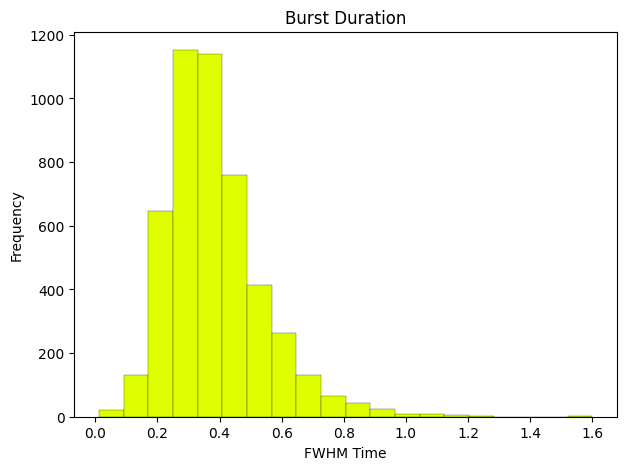

In [281]:
fwhm_times = []
for entry in burst_three:
    bursts = entry.get('bursts', {})
    fwhm_time_list = bursts.get('fwhm_time', [])
    for fwhm_time in fwhm_time_list:
        try:
            fwhm_times.append(float(fwhm_time))
        except ValueError:
            print(f"Invalid fwhm_time value: {fwhm_time}")

print("Extracted fwhm_times:", fwhm_times)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(fwhm_times, bins=20, color="#DFFF00", edgecolor='black', linewidth=0.2)
ax.set_title("Burst Duration")
ax.set_xlabel("FWHM Time")
ax.set_ylabel("Frequency")
plt.show()

Extracted fwhm_freqs: [1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 2.8571428571428577, 1.4285714285714288, 2.8571428571428577, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 2.8571428571428577, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 2.8571428571428577, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 2.8571428571428577, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 2.8571428571428577, 2.8571428571428577, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 1.4285714285714288, 4.2857142857142865, 1.4285714285714288, 1.428571428571428

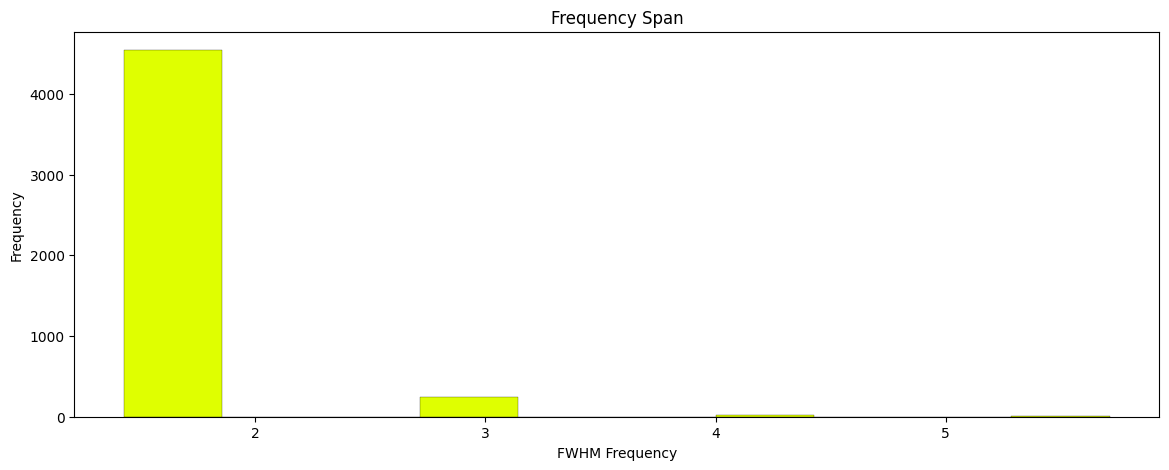

In [282]:
fwhm_times = []
fwhm_freqs = []
for entry in burst_three:
    bursts = entry.get('bursts', {})
    fwhm_freq_list = bursts.get('fwhm_freq', [])
    for freq_list in fwhm_freq_list:
        if isinstance(freq_list, list):
            for fwhm_freq in freq_list:
                try:
                    fwhm_freqs.append(float(fwhm_freq))
                except ValueError:
                    print(f"Invalid fwhm_freq value: {fwhm_freq}")
        else:
            try:
                fwhm_freqs.append(float(freq_list))
            except ValueError:
                print(f"Invalid fwhm_freq value: {freq_list}")

print("Extracted fwhm_freqs:", fwhm_freqs)

f, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.hist(fwhm_freqs, bins=10, color="#DFFF00", edgecolor='black', linewidth=0.2)
ax.set_title("Frequency Span")
ax.set_xlabel("FWHM Frequency")
ax.set_ylabel("Frequency")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Extracted peak_freqs: [9.285714285714285, 9.285714285714285, 9.285714285714285, 9.285714285714285, 9.285714285714285, 7.857142857142858, 18.57142857142857, 18.57142857142857, 17.857142857142858, 18.57142857142857, 17.857142857142858, 7.857142857142858, 6.428571428571429, 9.285714285714285, 11.428571428571429, 7.857142857142858, 6.428571428571429, 6.428571428571429, 7.142857142857142, 7.142857142857142, 10.0, 7.142857142857142, 7.142857142857142, 7.142857142857142, 7.142857142857142, 6.428571428571429, 6.428571428571429, 12.857142857142858, 12.857142857142858, 17.857142857142858, 17.857142857142858, 7.857142857142858, 8.571428571428571, 8.571428571428571, 7.142857142857142, 7.857142857142858, 10.714285714285715, 6.428571428571429, 10.0, 6.428571428571429, 8.571428571428571, 7.142857142857142, 10.714285714285715, 7.857142857142858, 7.142857142857142, 10.714285714285715, 7.857142857142858, 8.571428571428571, 9.285714285714285, 6.428571428571429, 10.714285714285715, 7.142857142857142, 7.14

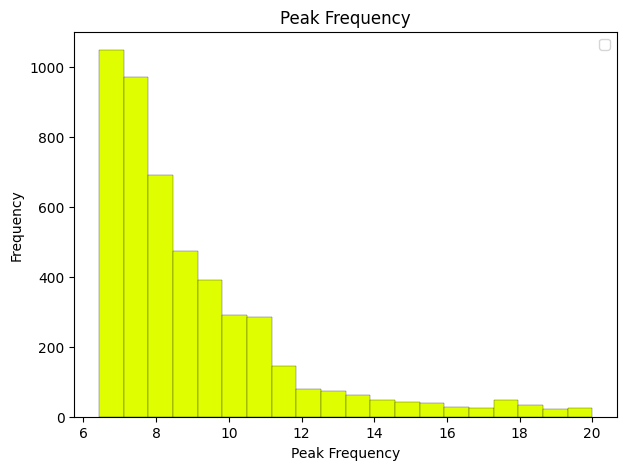

In [283]:
peak_freqs = []
for entry in burst_three:
    bursts = entry.get('bursts', {})
    peak_freq_list = bursts.get('peak_freq', [])
    for freq_list in peak_freq_list:
        if isinstance(freq_list, list):
            for peak_freq in freq_list:
                try:
                    peak_freqs.append(float(peak_freq))
                except ValueError:
                    print(f"Invalid peak_freq value: {peak_freq}")
        else:
            try:
                peak_freqs.append(float(freq_list))
            except ValueError:
                print(f"Invalid peak_freq value: {freq_list}")

print("Extracted peak_freqs:", peak_freqs)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(peak_freqs, bins=20, color="#DFFF00", edgecolor='black', linewidth=0.2)
#ax.plot(foi[search_range], residual_search_power*0.75e2, lw=0.5, c="black", label="scaled periodic power")
ax.legend()
ax.set_title("Peak Frequency")
ax.set_xlabel("Peak Frequency")
ax.set_ylabel("Frequency")
plt.show()

Extracted peak_amp_bases: [58.968426549717535, 37.129595504210656, 22.556056241999705, 34.87034058305045, 16.339011951075705, 11.560502508536267, 0.07014288137128166, 0.0187304670125224, 0.01598340445569052, 0.027470392410216593, 0.008762471083098133, 11.638107002644311, 41.81676193038036, 7.523734364209816, 6.9119976560307625, 4.061672567459559, 25.720435561097883, 8.092203099772494, 18.516603119750698, 7.410956678961313, 3.076788780213105, 5.6233388497341, 79.75369388326128, 18.44533859813938, 22.635839115423018, 11.904422025119715, 2.8853118800766717, 6.051358384388509, 4.089306252092465, 0.006219559404081476, 0.005182432038418894, 47.748818819326324, 8.491064688408766, 7.048937987525424, 8.398022510661349, 4.966107494283571, 0.6874458053215524, 12.923705074345975, 3.308019420094603, 40.96789374272725, 4.778851635386286, 32.382408397261734, 10.50623630060727, 9.076376751367905, 11.598217717277397, 5.626098113942571, 12.685788252465407, 4.7206007470924725, 2.9493060843827923, 2.89574

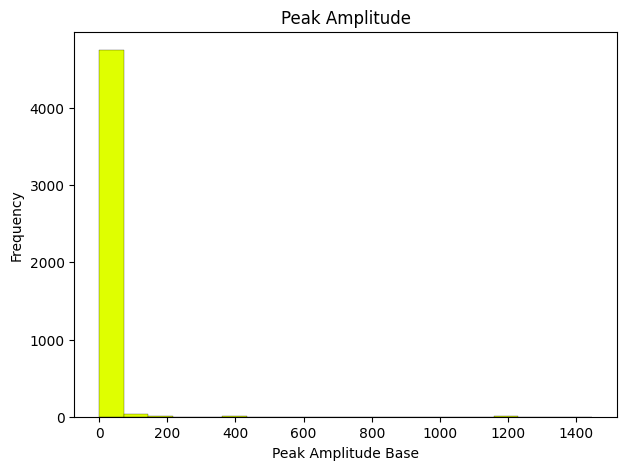

In [284]:
peak_amp_bases = []
for entry in burst_three:
    bursts = entry.get('bursts', {})
    peak_amp_base_list = bursts.get('peak_amp_base', [])
    for amp_list in peak_amp_base_list:
        if isinstance(amp_list, list):
            for peak_amp_base in amp_list:
                try:
                    peak_amp_bases.append(float(peak_amp_base))
                except ValueError:
                    print(f"Invalid peak_amp_base value: {peak_amp_base}")
        else:
            try:
                peak_amp_bases.append(float(amp_list))
            except ValueError:
                print(f"Invalid peak_amp_base value: {amp_list}")

print("Extracted peak_amp_bases:", peak_amp_bases)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(peak_amp_bases, bins=20, color="#DFFF00", edgecolor='black', linewidth=0.2)
ax.set_title("Peak Amplitude")
ax.set_xlabel("Peak Amplitude Base")
ax.set_ylabel("Frequency")
plt.show()

Extracted peak_amp_bases: [58.968426549717535, 37.129595504210656, 22.556056241999705, 34.87034058305045, 16.339011951075705, 11.560502508536267, 0.07014288137128166, 0.0187304670125224, 0.01598340445569052, 0.027470392410216593, 0.008762471083098133, 11.638107002644311, 41.81676193038036, 7.523734364209816, 6.9119976560307625, 4.061672567459559, 25.720435561097883, 8.092203099772494, 18.516603119750698, 7.410956678961313, 3.076788780213105, 5.6233388497341, 79.75369388326128, 18.44533859813938, 22.635839115423018, 11.904422025119715, 2.8853118800766717, 6.051358384388509, 4.089306252092465, 0.006219559404081476, 0.005182432038418894, 47.748818819326324, 8.491064688408766, 7.048937987525424, 8.398022510661349, 4.966107494283571, 0.6874458053215524, 12.923705074345975, 3.308019420094603, 40.96789374272725, 4.778851635386286, 32.382408397261734, 10.50623630060727, 9.076376751367905, 11.598217717277397, 5.626098113942571, 12.685788252465407, 4.7206007470924725, 2.9493060843827923, 2.89574

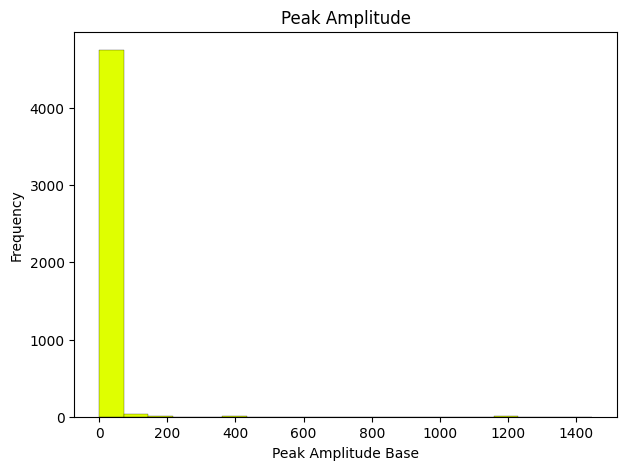

In [285]:
peak_amp_bases = []
for entry in burst_three:
    bursts = entry.get('bursts', {})
    peak_amp_base_list = bursts.get('peak_amp_base', [])
    for peak_amp_base in peak_amp_base_list:
        if isinstance(peak_amp_base, list):
            for amp in peak_amp_base:
                try:
                    peak_amp_bases.append(float(amp))
                except ValueError:
                    print(f"Invalid peak_amp_base value: {amp}")
        else:
            try:
                peak_amp_bases.append(float(peak_amp_base))
            except ValueError:
                print(f"Invalid peak_amp_base value: {peak_amp_base}")

print("Extracted peak_amp_bases:", peak_amp_bases)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(peak_amp_bases, bins=20, color="#DFFF00", edgecolor='black', linewidth=0.2)
ax.set_title("Peak Amplitude")
ax.set_xlabel("Peak Amplitude Base")
ax.set_ylabel("Frequency")
plt.show()

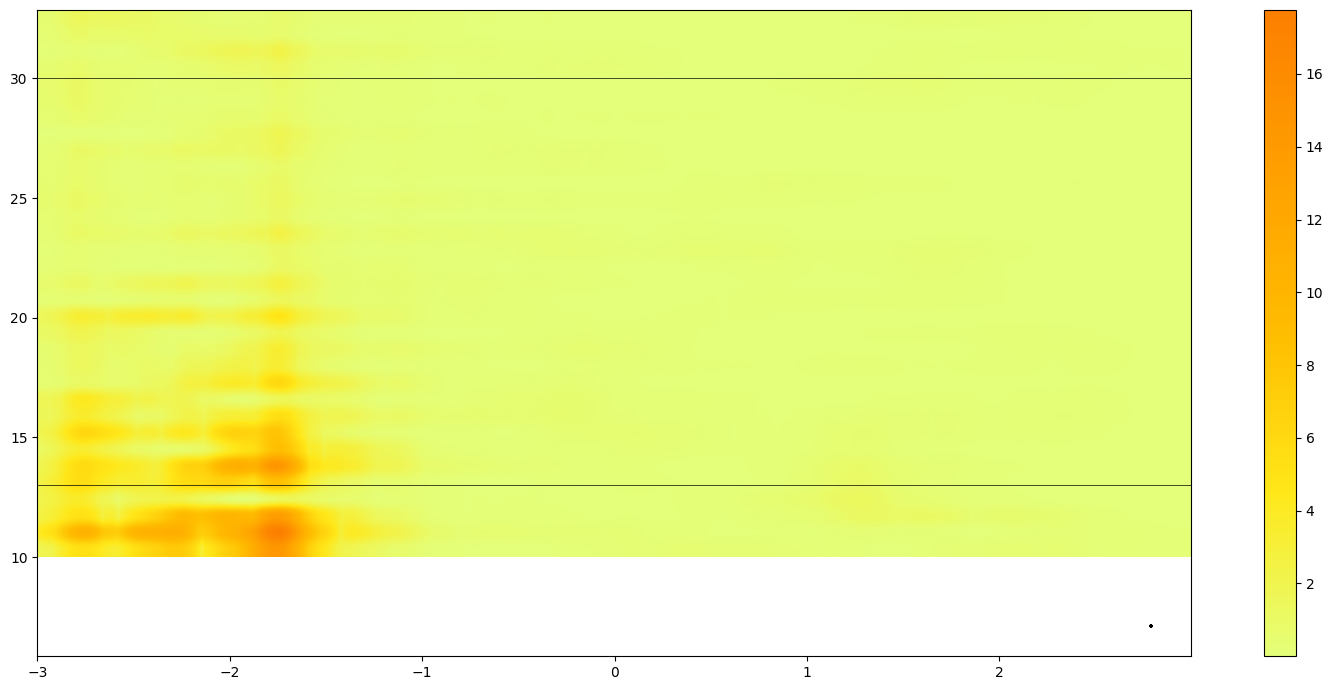

In [271]:
trial = 10
tr_map = bursts["trial"] == trial
f, ax = plt.subplots(1,1, figsize=(15, 7))
spectrum = ax.imshow(trial_tf[trial][search_range], cmap="Wistia", origin="lower", extent=(times[0], times[-1], foi[search_range][0], foi[search_range][-1]), aspect="auto")
ax.scatter(bursts["peak_time"][tr_map], bursts["peak_freq"][tr_map], s=10, marker="+", c="black")
ax.axhline(beta_lims[0], lw=0.5, c="black")
ax.axhline(beta_lims[1], lw=0.5, c="black")
plt.colorbar(spectrum, ax=ax)
plt.tight_layout()